## Salesforce 1B: Market Mood to Financial Moves
### data preprocessing + feat engineering

This goal of this notebook is to go through data processing steps on the yFinance and Kaggle Financial News Headlines data.

## Yfinance Data

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
df = yf.download("SPY", start="2017-12-30", end="2020-07-19")
df.head()

/tmp/ipython-input-2577717249.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start="2017-12-30", end="2020-07-19")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700
2018-01-03,239.413940,239.564432,238.077314,238.077314,90070400
2018-01-04,240.423019,240.909883,239.475900,240.060120,80636400
2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000
2018-01-08,242.467804,242.627129,241.635735,241.927832,57319200


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
start_date = df.index.min()
end_date = df.index.max()

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
num_business_days = len(pd.date_range(start=start_date, end=end_date, freq=us_bd))

print(f"Number of rows in the data: {df.shape[0]}")
print(f"Number of business days between {start_date.date()} and {end_date.date()}: {num_business_days}")
print("\nDate range in the data:")
print(f"Start date: {start_date.date()}")
print(f"End date: {end_date.date()}")

Number of rows in the data: 640
Number of business days between 2018-01-02 and 2020-07-17: 640

Date range in the data:
Start date: 2018-01-02
End date: 2020-07-17


In [ ]:
df.isnull().sum()

,,0
Price,Ticker,
Close,SPY,0
High,SPY,0
Low,SPY,0
Open,SPY,0
Volume,SPY,0


## EDA on data

first we want to inspect the patterns of the opening prices over time for the SPY stock

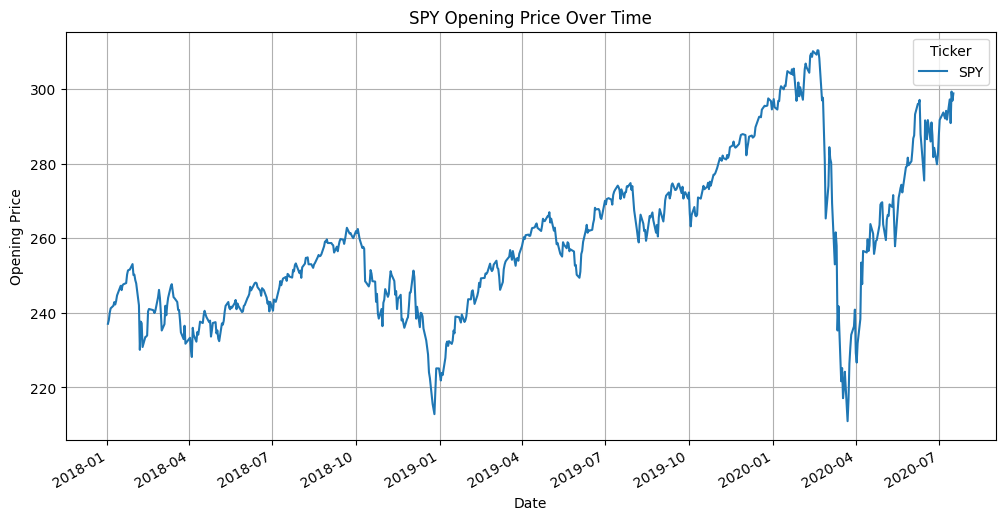

In [ ]:
df['Open'].plot(figsize=(12, 6), title='SPY Opening Price Over Time')
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.grid(True)
plt.show()

The SPY opening price from 2018-2020 exhibits a general upward trend with a steady increase from ~240 to ~300. There is a however, a sharp drop during early 2020 which is likely reflective of the COVID market crash at the time. This is followed by a strong rebound.

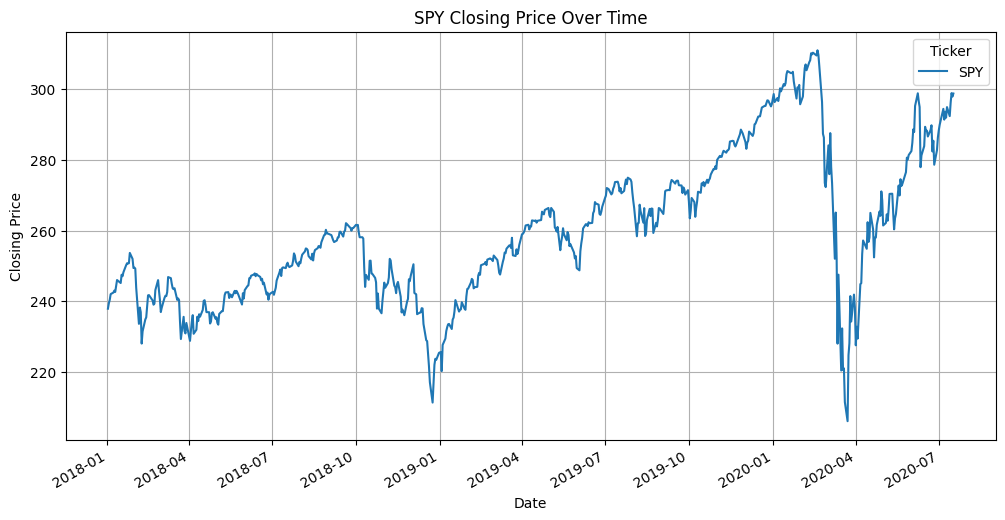

In [ ]:
df['Close'].plot(figsize=(12, 6), title='SPY Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

We observe the same trends in closing price which makes sense.

We'll proceed with using the closing price as that would be the easiest to use to predict the next day's opening price.

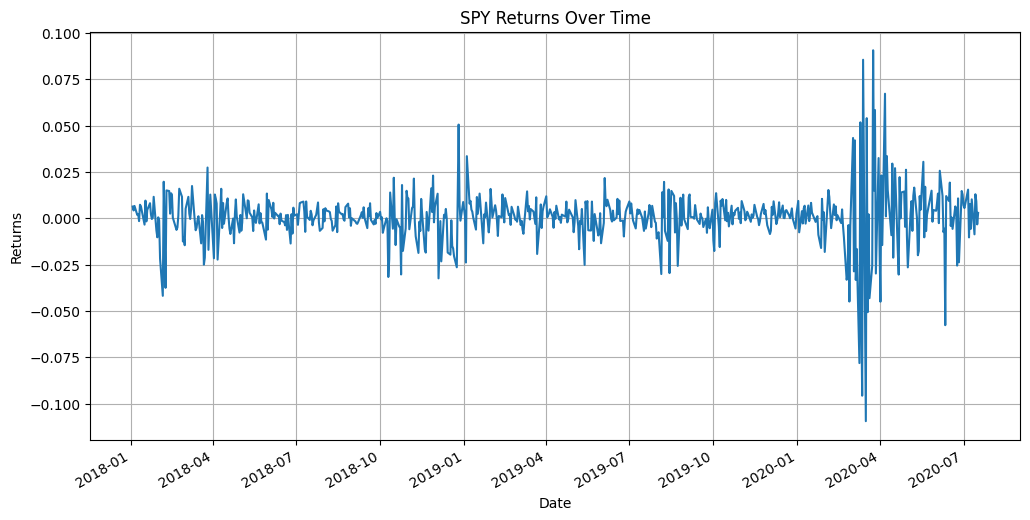

In [ ]:
df['Return'] = df['Close'].pct_change()
df['Return'].plot(figsize=(12, 6), title='SPY Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

daily returns observations:
- most daily returns are very small, typically within the -1% to +1% range
- occasional large spikes during major market events (COVID)
- voltality is not constant
- small movements in market might be difficult to predict using new headlines..
  - threshold-based labeling?

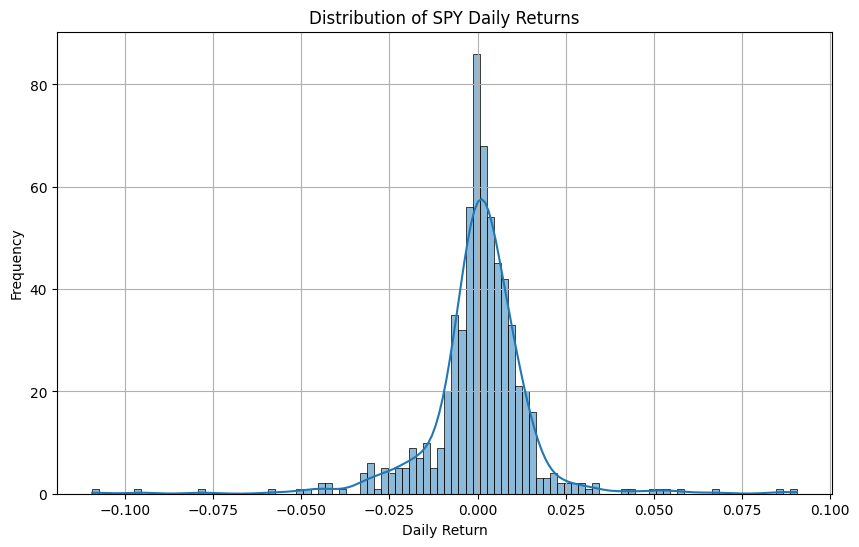

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Return'].dropna(), bins=100, kde=True)
plt.title("Distribution of SPY Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

the distribution of returns tells us that small movements are VERY common.

In [ ]:
df['Volatility_20'] = df['Return'].rolling(20).std()

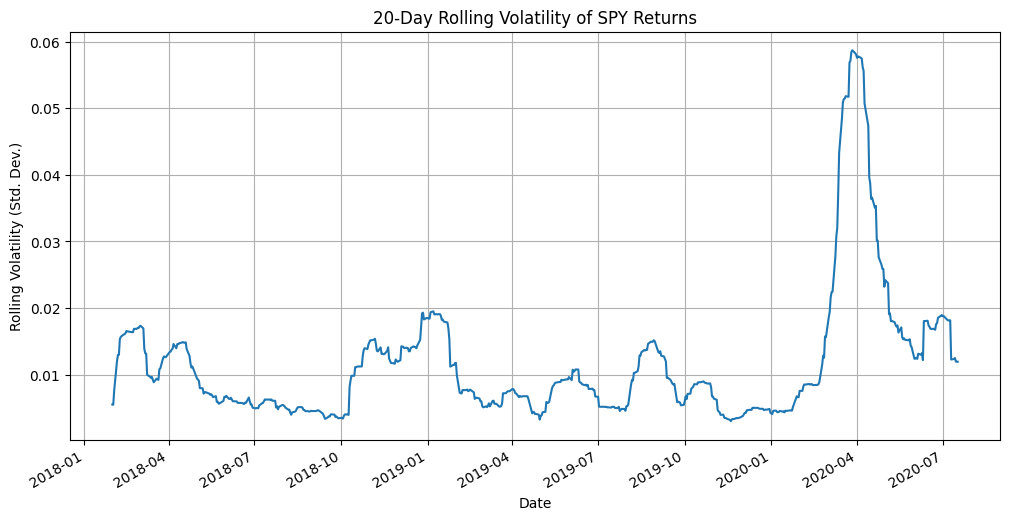

In [ ]:
plt.figure(figsize=(12, 6))
df['Volatility_20'].plot()
plt.title('20-Day Rolling Volatility of SPY Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility (Std. Dev.)')
plt.grid(True)
plt.show()

voltality is generally low, other than during the covid spike.

Now we check the class balance to see how many values in our dataset resulted in a next day increase/decrease

In [ ]:
df['Next_Return'] = df['Return'].shift(-1)
df['Label'] = (df['Next_Return'] > 0).astype(int)
df['Label'].value_counts()

,count
Label,
1,360
0,280


dataset shows a slight upward bias
- 56% up days/ 44% down days
- accuracy alone won't be the best metric bc of this slight imbalance.


Now we'll inspect the data to find days where there may have been extreme spikes in returns/ losses.

In [ ]:
worst = df.nsmallest(10, 'Return')[['Return']]
worst

Price,Return
Ticker,
Date,
2020-03-16,-0.109424
2020-03-12,-0.095677
2020-03-09,-0.078094
2020-06-11,-0.057649
2020-03-18,-0.050633
2020-03-11,-0.048749
2020-04-01,-0.045005
2020-02-27,-0.044912


In [ ]:
best = df.nlargest(10, 'Return')[['Return']]
best

Price,Return
Ticker,
Date,
2020-03-24,0.090603
2020-03-13,0.085486
2020-04-06,0.067166
2020-03-26,0.058390
2020-03-17,0.053992
2020-03-10,0.051745
2018-12-26,0.050525
2020-03-02,0.043307


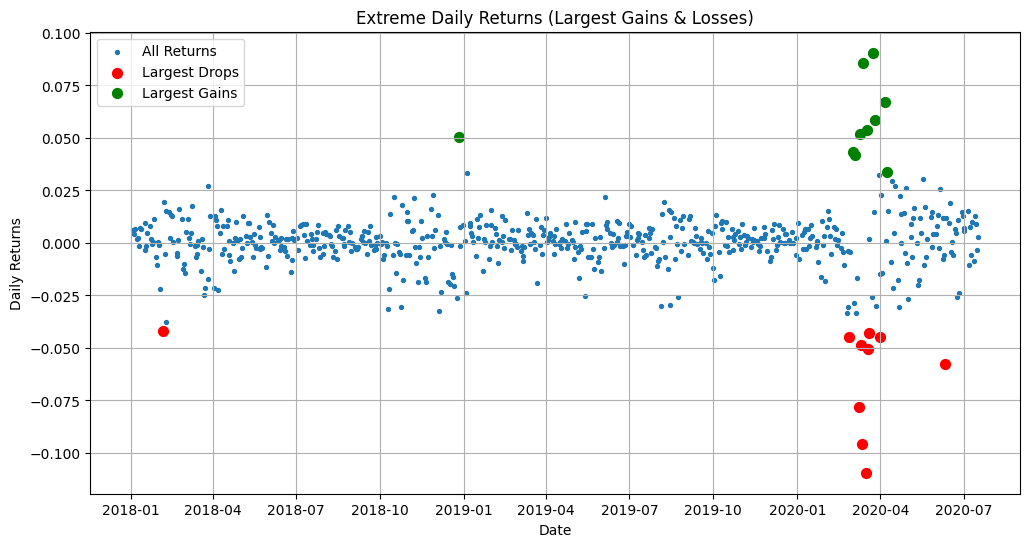

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Return'], s=8, label='All Returns')
plt.scatter(worst.index, worst['Return'], color='red', s=50, label='Largest Drops')
plt.scatter(best.index, best['Return'], color='green', s=50, label='Largest Gains')
plt.title("Extreme Daily Returns (Largest Gains & Losses)")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.grid(True)
plt.legend()
plt.show()

- largest negative returns mostly occur in marc/april 2020, during the COVID market crash, with drops between -5% and -11%.

- largest positive returns also appear in early 2020 with rebound days with gains of +5% to +9%.

- one notable outlier before 2020 (~ -4.5% in early 2018)

- outside of crisis periods, extreme moves are much smaller

- fat-tailed nature of data of returns show that major news events drive the biggest market movements

## Financial News Headlines Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("notlucasp/financial-news-headlines")

Using Colab cache for faster access to the 'financial-news-headlines' dataset.


In [ ]:
cnbc = pd.read_csv(path + "/cnbc_headlines.csv")
guardian = pd.read_csv(path + "/guardian_headlines.csv")
reuters = pd.read_csv(path + "/reuters_headlines.csv")

# convert to dataframes
cnbc_df = pd.DataFrame(cnbc)
guardian_df = pd.DataFrame(guardian)
reuters_df = pd.DataFrame(reuters)

In [ ]:
cnbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [ ]:
cnbc_df["Description"][0]

'"Mad Money" host Jim Cramer recommended buying four companies that are supporting vaccine developers.'

In [ ]:
guardian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17800 entries, 0 to 17799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       17800 non-null  object
 1   Headlines  17800 non-null  object
dtypes: object(2)
memory usage: 278.3+ KB


In [ ]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32770 entries, 0 to 32769
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    32770 non-null  object
 1   Time         32770 non-null  object
 2   Description  32770 non-null  object
dtypes: object(3)
memory usage: 768.2+ KB


In [ ]:
reuters_df["Description"][0]

'TikTok has been in discussions with the UK government over the past few months to locate its headquarters in London, a source familiar with the matter said, as part of a strategy to distance itself from its Chinese ownership.'

Of the three new sources, it looks like guardian is the only one without a description. for sake of maintaining consistency across sources and avoiding introducing variable-length text bias, we will keep only the headline field for all datasets. Headlines itself already provides concise, high-signal information.

In [ ]:
cnbc_df = cnbc_df.rename(columns={'Headlines': 'headline'})
guardian_df = guardian_df.rename(columns={'Headlines': 'headline'})
reuters_df = reuters_df.rename(columns={'Headlines': 'headline'})
# source
cnbc_df['source'] = 'cnbc'
guardian_df['source'] = 'guardian'
reuters_df['source'] = 'reuters'

converting the dates across all 3 sources to be the same format.

In [ ]:
# parsing for guardian and reuters
guardian_df['date'] = pd.to_datetime(guardian_df['Time'], format="%d-%b-%y", errors='coerce')
reuters_df['date'] = pd.to_datetime(reuters_df['Time'], format="%b %d %Y", errors='coerce')

In [ ]:
import re
from dateutil import parser

def parse_cnbc_time(time_str):
    if pd.isna(time_str):
        return None
    match = re.search(r",\s*(.*)", time_str)
    if match:
        date_str = match.group(1)
        try:
            return parser.parse(date_str)
        except:
            return None
    return None

cnbc_df['date'] = cnbc_df['Time'].apply(parse_cnbc_time)

handling missing dates

In [ ]:
cnbc_df['date'].isna().sum()

np.int64(280)

In [ ]:
cnbc_df = cnbc_df.dropna(subset=['headline', 'date'])
guardian_df = guardian_df.dropna(subset=['headline', 'date'])
reuters_df = reuters_df.dropna(subset=['headline', 'date'])

combining the 3 sources

In [ ]:
news_all = pd.concat([cnbc_df[['headline', 'date', 'source']],
                      guardian_df[['headline', 'date', 'source']],
                      reuters_df[['headline', 'date', 'source']]],
                     ignore_index=True)

In [ ]:
news_all.isna().sum()

,0
headline,0
date,0
source,0


now that we have the 3 new sources data merged, we'll proceed with normalizing/cleaning the data.


we'll start with doing the following for each headline:
- lowercase
- remove urls
- remove line breaks/tabs
- remove special chars
- collapse multiple spaces
- remove stopwords

In [ ]:
!pip install contractions

In [ ]:
import re
import contractions
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_headline(text):
    if pd.isna(text):
        return ""
    # lowercase
    text = contractions.fix(text)
    text = text.lower()

    # remove urls
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # remove newline / tabs
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")

    # remove weird special chars
    text = re.sub(r"[^a-z0-9 ]", " ", text)

    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    # remove stopwords
    tokens = [w for w in text.split() if w not in ENGLISH_STOP_WORDS]
    text = " ".join(tokens)

    return text

In [ ]:
news_all['headline_clean'] = news_all['headline'].astype(str).apply(clean_headline)
# drop rows that became empty after cleaning
news_all = news_all[news_all['headline_clean'].str.len() > 0].copy()
news_all.head()

,headline,date,source,headline_clean
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,cnbc,jim cramer better way invest covid 19 vaccine ...
1,Cramer's lightning round: I would own Teradyne,2020-07-17,cnbc,cramer s lightning round teradyne
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,cnbc,cramer s week ahead big week earnings bigger w...
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,cnbc,iq capital ceo keith bliss says tech healthcar...
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,cnbc,wall street delivered kind pullback waiting ji...


inspecting the results

In [ ]:
news_all["headline_clean"][50]

'barstool s dave portnoy says focus sports betting sports return'

In [ ]:
news_all["headline"][50]

"Barstool's Dave Portnoy says he'll focus on sports betting when sports return"

now that we've normalized the format of the headlines we'll work on normalizing the dates and then merging.

In [ ]:
if not isinstance(df.index, pd.DatetimeIndex):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
df = df.sort_index()
trading_days = df.index.normalize().unique().sort_values()

In [ ]:
news_all['date'] = pd.to_datetime(news_all['date'], errors='coerce')
news_all['date_only'] = news_all['date'].dt.normalize()
# drop rows where we couldn't parse a date
news_all = news_all.dropna(subset=['date_only'])
trade_df = pd.DataFrame({'trade_date': trading_days}).sort_values('trade_date')
news_all = news_all.sort_values('date_only')

# map each news date to the SAME or NEXT trading day
news_all = pd.merge_asof(
    news_all,
    trade_df,
    left_on='date_only',
    right_on='trade_date',
    direction='forward'   # next trading day
)

# drop anything that mapped past the last trading day
news_all = news_all.dropna(subset=['trade_date'])


aggregate headlines by trading day

In [ ]:
daily_news = (
    news_all
    .groupby('trade_date')['headline_clean']
    .apply(lambda x: " ".join(x))
    .to_frame(name='headline_concat')
)

In [ ]:
df.index = df.index.normalize()
merged = df.join(daily_news, how='left')
merged.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return_,Volatility_20_,Next_Return_,Label_,headline_concat
Date,,,,,,,,,,
2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700,NaN,NaN,0.006325,1,guardian view ryanair s model union friendly c...
2018-01-03,239.413940,239.564432,238.077314,238.077314,90070400,0.006325,NaN,0.004215,1,business live uk construction growth disappoin...
2018-01-04,240.423019,240.909883,239.475900,240.060120,80636400,0.004215,NaN,0.006664,1,uk leaving single market tpp hit workers right...
2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000,0.006664,NaN,0.001829,1,guardian s audio long reads manchester city s ...
2018-01-08,242.467804,242.627129,241.635735,241.927832,57319200,0.001829,NaN,0.002264,1,business live wall street ftse 100 hit new hig...


In [ ]:
df.columns

Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return_',
       'Volatility_20_', 'Next_Return_', 'Label_'],
      dtype='object')

In [ ]:
daily_news.iloc[3]

,2018-01-05
headline_concat,guardian s audio long reads manchester city s ...


In [ ]:
news_all[news_all["date"] == "2018-01-05"].count()

,0
headline,32
date,32
source,32
headline_clean,32
date_only,32
trade_date,32


In [ ]:
pd.set_option('display.max_colwidth', None)
merged[['headline_concat']].head()
merged['headline_concat'].iloc[0]

'guardian view ryanair s model union friendly company butchers carve niche uk shoppers opt indie stores grogonomics year companies jobs 2018 wages youngest staff given uk workplace pensions qualifying age cut peter preston press broadcasting paul dacre pay best spend mail millions unilever sells household spreads kkr 6bn david cameron lead 750m uk china investment initiative mall operators buy e retail new use space global shopping centre giants christmas buying spree global desire buy british bad thing uk tech firms business prosper corbyn government britons set new gin record buying 47m bottles year british steel pension scheme members preyed financial firms going furniture ombudsman sofa waste time uber stole trade secrets bribed foreign officials spied rivals filing says hundreds lose jobs britvic shuts norwich factory site investing solar energy create brighter future africa poundland suppliers hit insurance downgrade cryptocurrencies city watchdog investigate new fundraising tren

In [ ]:
df.shape

(640, 9)

In [ ]:
df.index.max()

Timestamp('2020-07-17 00:00:00')

In [ ]:
df.index.min()

Timestamp('2018-01-02 00:00:00')

## inspecting merged dataset

In [ ]:
merged.describe()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return_,Volatility_20_,Next_Return_,Label_
count,640.000000,640.000000,640.000000,640.000000,6.400000e+02,639.000000,620.000000,639.000000,640.000000
mean,259.407779,261.000214,257.653650,259.407356,9.287317e+07,0.000469,0.011502,0.000469,0.562500
std,20.407810,20.100840,20.696186,20.406703,5.588194e+07,0.014991,0.009973,0.014991,0.496466
min,206.111832,212.333548,201.776039,210.956089,2.027000e+07,-0.109424,0.003002,-0.109424,0.000000
25%,243.681805,244.999066,242.047852,243.663893,5.753465e+07,-0.003758,0.005378,-0.003758,0.000000
50%,257.246445,258.631812,255.201628,257.137171,7.675915e+07,0.000862,0.008535,0.000862,1.000000
75%,272.217773,273.429975,270.671303,272.309812,1.051505e+08,0.006682,0.013989,0.006682,1.000000
max,310.958557,311.638661,310.168169,310.453079,3.922207e+08,0.090603,0.058701,0.090603,1.000000


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2018-01-02 to 2020-07-17
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Close_SPY        640 non-null    float64
 1   High_SPY         640 non-null    float64
 2   Low_SPY          640 non-null    float64
 3   Open_SPY         640 non-null    float64
 4   Volume_SPY       640 non-null    int64  
 5   Return_          639 non-null    float64
 6   Volatility_20_   620 non-null    float64
 7   Next_Return_     639 non-null    float64
 8   Label_           640 non-null    int64  
 9   headline_concat  639 non-null    object 
dtypes: float64(7), int64(2), object(1)
memory usage: 55.0+ KB


In [ ]:
pd.reset_option('display.max_colwidth')
merged.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return_,Volatility_20_,Next_Return_,Label_,headline_concat
Date,,,,,,,,,,
2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700,NaN,NaN,0.006325,1,guardian view ryanair s model union friendly c...
2018-01-03,239.413940,239.564432,238.077314,238.077314,90070400,0.006325,NaN,0.004215,1,business live uk construction growth disappoin...
2018-01-04,240.423019,240.909883,239.475900,240.060120,80636400,0.004215,NaN,0.006664,1,uk leaving single market tpp hit workers right...
2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000,0.006664,NaN,0.001829,1,guardian s audio long reads manchester city s ...
2018-01-08,242.467804,242.627129,241.635735,241.927832,57319200,0.001829,NaN,0.002264,1,business live wall street ftse 100 hit new hig...


checking missing values

In [ ]:
merged.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return_,1
Volatility_20_,20
Next_Return_,1
Label_,0
headline_concat,1


- volatility_20: this makes sense given the 20 day shift
- next_return : 1 missing is due to the shift in 1
- headline_concat: one day didnt align well with news headlines so we can just fill it with a blank quote

In [ ]:
merged['headline_concat'] = merged['headline_concat'].fillna("")

In [ ]:
merged.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return_,1
Volatility_20_,20
Next_Return_,1
Label_,0
headline_concat,0


After adressing the values, we can now begin the feature engineering process.

# Feature Engineering

In [ ]:
model_df = merged.drop(columns=['Volatility_20_', 'Return_', 'Next_Return_', 'Label_']).copy()

In [ ]:
model_df.head()

,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,headline_concat
Date,,,,,,
2018-01-02,237.909164,237.944579,236.696475,237.085956,86655700,guardian view ryanair s model union friendly c...
2018-01-03,239.413940,239.564432,238.077314,238.077314,90070400,business live uk construction growth disappoin...
2018-01-04,240.423019,240.909883,239.475900,240.060120,80636400,uk leaving single market tpp hit workers right...
2018-01-05,242.025238,242.149149,240.724026,241.219723,83524000,guardian s audio long reads manchester city s ...
2018-01-08,242.467804,242.627129,241.635735,241.927832,57319200,business live wall street ftse 100 hit new hig...


In [ ]:
features_df = merged.copy()

# Price spreads
features_df["High_Low_Spread"] = features_df["High_SPY"] - features_df["Low_SPY"]
features_df["Close_Open_Change"] = features_df["Close_SPY"] - features_df["Open_SPY"]

# Moving averages
features_df["MA_5"] = features_df["Close_SPY"].rolling(window=5).mean()
features_df["MA_20"] = features_df["Close_SPY"].rolling(window=20).mean()
features_df["MA_50"] = features_df["Close_SPY"].rolling(window=50).mean()

# Momentum (returns)
features_df["Return_5"] = features_df["Close_SPY"].pct_change(5)
features_df["Return_10"] = features_df["Close_SPY"].pct_change(10)

# Seasonality
features_df["day_of_week"] = features_df.index.dayofweek
features_df["month"] = features_df.index.month
features_df["is_month_end"] = features_df.index.is_month_end.astype(int)
features_df["is_quarter_end"] = features_df.index.is_quarter_end.astype(int)


###inspecting moving averages over time

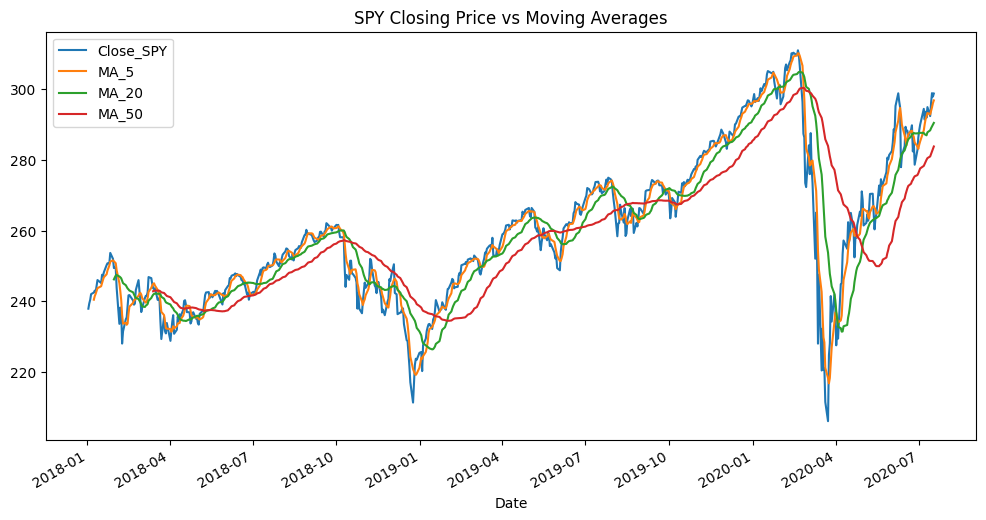

In [ ]:
features_df[['Close_SPY','MA_5','MA_20','MA_50']].plot(figsize=(12,6))
plt.title("SPY Closing Price vs Moving Averages")
plt.show()

Short-, medium-, and long-term moving averages were computed to capture different levels of trend. MA_5 closely tracks daily fluctuations, MA_20 captures medium-term trend shifts, and MA_50 represents long-term market direction. During the COVID-19 crash, all averages reacted at different speeds, confirming correct implementation. These features help the model understand momentum and trend strength at varying time horizons

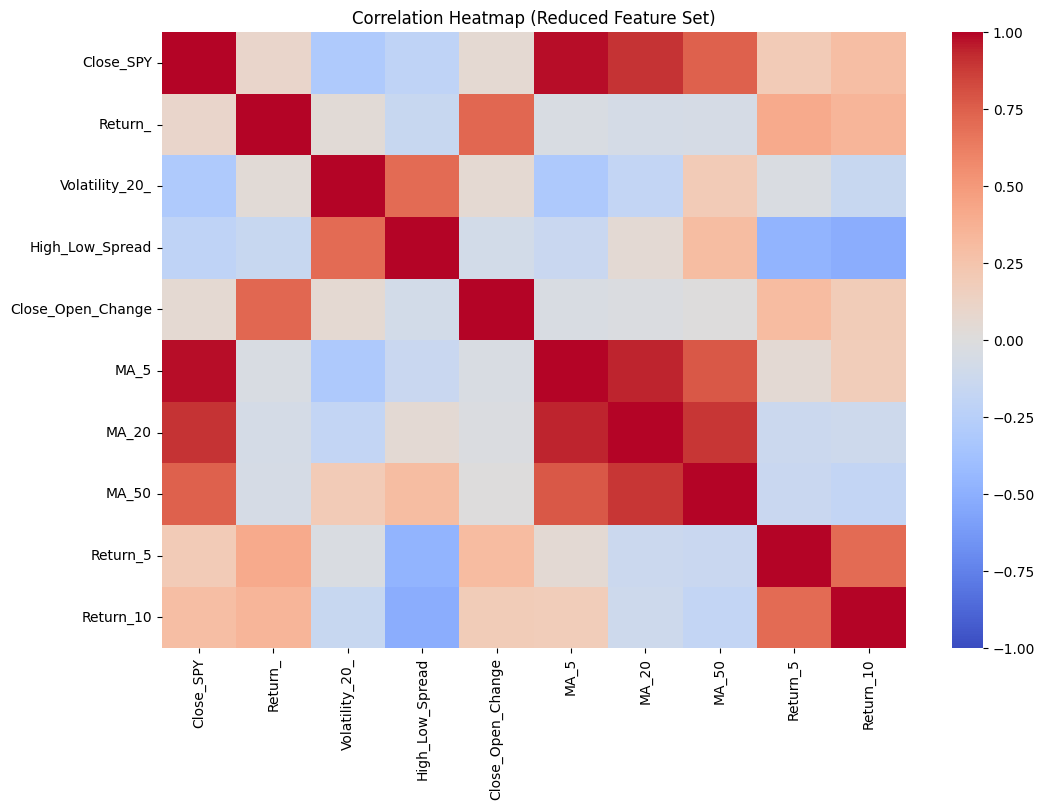

In [ ]:
reduced_numeric_features = [
    'Close_SPY',
    'Return_',
    'Volatility_20_',
    'High_Low_Spread',
    'Close_Open_Change',
    'MA_5', 'MA_20', 'MA_50',
    'Return_5', 'Return_10'
]

plt.figure(figsize=(12,8))
corr = features_df[reduced_numeric_features].corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap (Reduced Feature Set)")
plt.show()


**correlation heatmap summary**
- moving avgerages (ma_5, ma_20, ma_50)
  - highly correlated w/ each other
  - expected b/c they're just smooth versions of closing prices

- volatility_20
  - distinct correlation pattern
  - short-term trends

- price spread features (high_low_spread, close..)
  - low correlation w/ others

**model implications**
- linear models
  - use only one MA
  - use only one multi-day return feature
- tree models
  - can use all features

Now that we've finished numerical feature engineering, we'll calculate some sentiment scores for additional features

In [ ]:
!pip install vaderSentiment

**Applying VADER** (a rule-based sentiment analyzer) to each day's combined headlines.

For every headline bundle, VADER outputs four scores:

- neg: proportion of negative emotion

- neu: proportion of neutral content

- pos: proportion of positive emotion

- compound: a single overall sentiment score in [-1, +1]

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_scores(text):
    return analyzer.polarity_scores(text)
vader_dicts = features_df['headline_concat'].apply(get_vader_scores)

In [ ]:
features_df['vader_neg'] = vader_dicts.apply(lambda d: d['neg'])
features_df['vader_neu'] = vader_dicts.apply(lambda d: d['neu'])
features_df['vader_pos'] = vader_dicts.apply(lambda d: d['pos'])
features_df['vader_compound'] = vader_dicts.apply(lambda d: d['compound'])


The compound score is essentially a weighted combination of neg/neu/pos and represents the overall tone:

- close to +1 = very positive

- close to -1 = very negative

These scores were added back to the dataset as numeric features for modeling:

- vader_neg, vader_neu, vader_pos, vader_compound

In [ ]:
features_df[['headline_concat', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].head()

,headline_concat,vader_neg,vader_neu,vader_pos,vader_compound
Date,,,,,
2018-01-02,guardian view ryanair s model union friendly c...,0.136,0.728,0.136,-0.7411
2018-01-03,business live uk construction growth disappoin...,0.141,0.671,0.188,0.9333
2018-01-04,uk leaving single market tpp hit workers right...,0.158,0.685,0.157,0.1681
2018-01-05,guardian s audio long reads manchester city s ...,0.116,0.798,0.087,-0.8442
2018-01-08,business live wall street ftse 100 hit new hig...,0.159,0.702,0.139,-0.6829


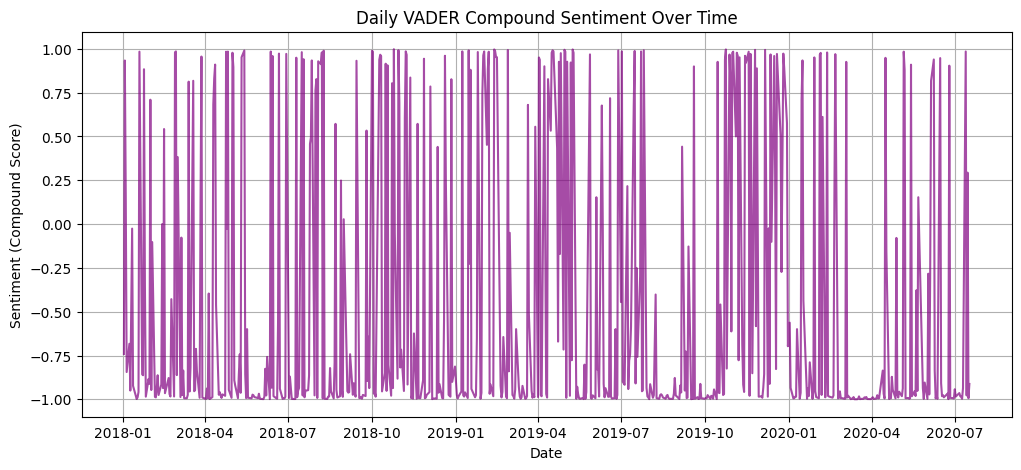

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(features_df.index, features_df['vader_compound'], color='purple', alpha=0.7)
plt.title("Daily VADER Compound Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment (Compound Score)")
plt.grid(True)
plt.show()

very noisy...

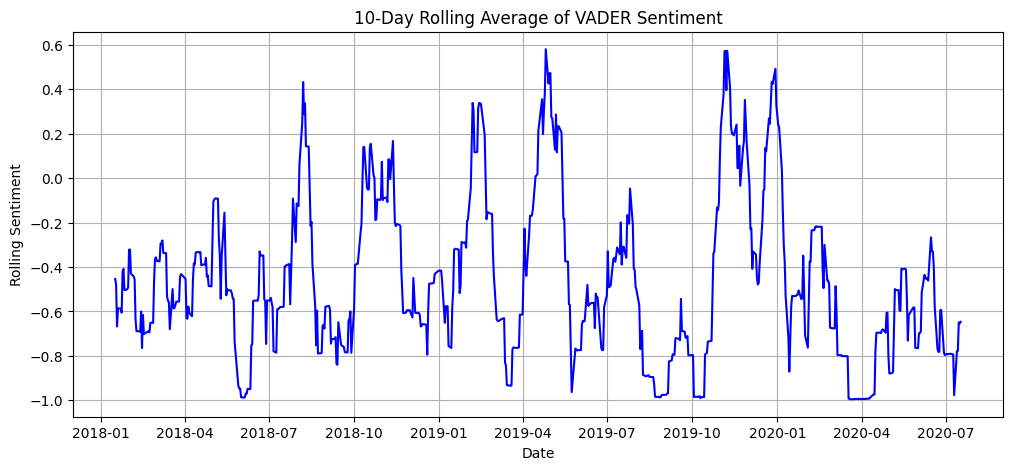

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(features_df['vader_compound'].rolling(10).mean(), color='blue')
plt.title("10-Day Rolling Average of VADER Sentiment")
plt.xlabel("Date")
plt.ylabel("Rolling Sentiment")
plt.grid(True)
plt.show()


meaningful news cycle- periods of positive / negative new waves can be seen

###FINBERT

In [ ]:
!pip install transformers --quiet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Load FinBERT
finbert_model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert"
)
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_pipeline = pipeline(
    "sentiment-analysis",
    model=finbert_model,
    tokenizer=finbert_tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


FinBERT is a finance-specific sentiment model trained on earnings calls, analyst reports, and financial news.

It assigns three probabilities:

- positive

- negative

- neutral

In [ ]:
def finbert_scores(text):
    try:
        scores = finbert_pipeline(text[:512])[0]  # truncate to avoid long input
        out = {d['label'].lower(): d['score'] for d in scores}
        return out
    except:
        return {"positive": 0, "negative": 0, "neutral": 1}

In [ ]:
finbert_dicts = features_df['headline_concat'].apply(finbert_scores)

In [ ]:
features_df['finbert_positive'] = finbert_dicts.apply(lambda d: d['positive'])
features_df['finbert_negative'] = finbert_dicts.apply(lambda d: d['negative'])
features_df['finbert_neutral']  = finbert_dicts.apply(lambda d: d['neutral'])

In [ ]:
features_df[['headline_concat','finbert_positive','finbert_negative','finbert_neutral']].head()

,headline_concat,finbert_positive,finbert_negative,finbert_neutral
Date,,,,
2018-01-02,guardian view ryanair s model union friendly c...,0.068409,0.127347,0.804245
2018-01-03,business live uk construction growth disappoin...,0.604483,0.115324,0.280193
2018-01-04,uk leaving single market tpp hit workers right...,0.037523,0.760287,0.202190
2018-01-05,guardian s audio long reads manchester city s ...,0.273576,0.033745,0.692680
2018-01-08,business live wall street ftse 100 hit new hig...,0.220003,0.650369,0.129628


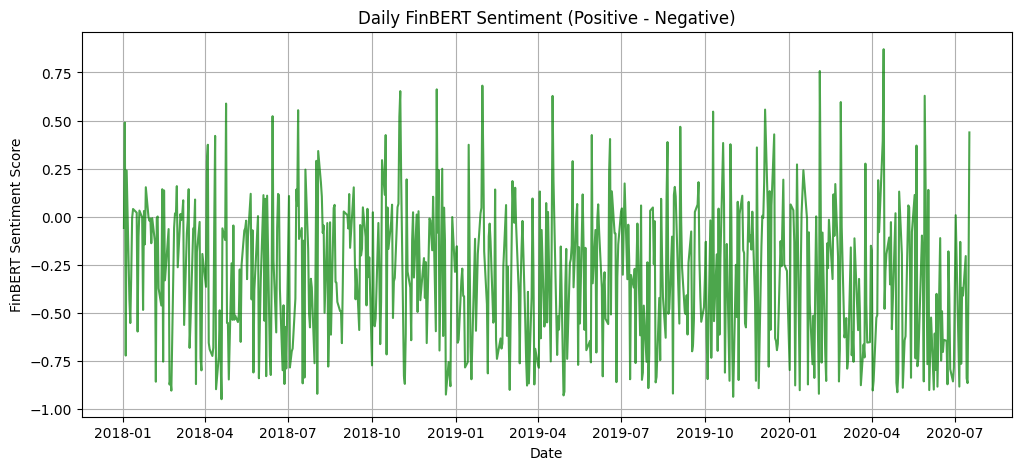

In [ ]:
plt.figure(figsize=(12,5))
finbert_signal = features_df['finbert_positive'] - features_df['finbert_negative']
plt.plot(features_df.index, finbert_signal, color='green', alpha=0.7)
plt.title("Daily FinBERT Sentiment (Positive - Negative)")
plt.xlabel("Date")
plt.ylabel("FinBERT Sentiment Score")
plt.grid(True)
plt.show()

the daily FinBERT sentiment signal is also quite volatile.

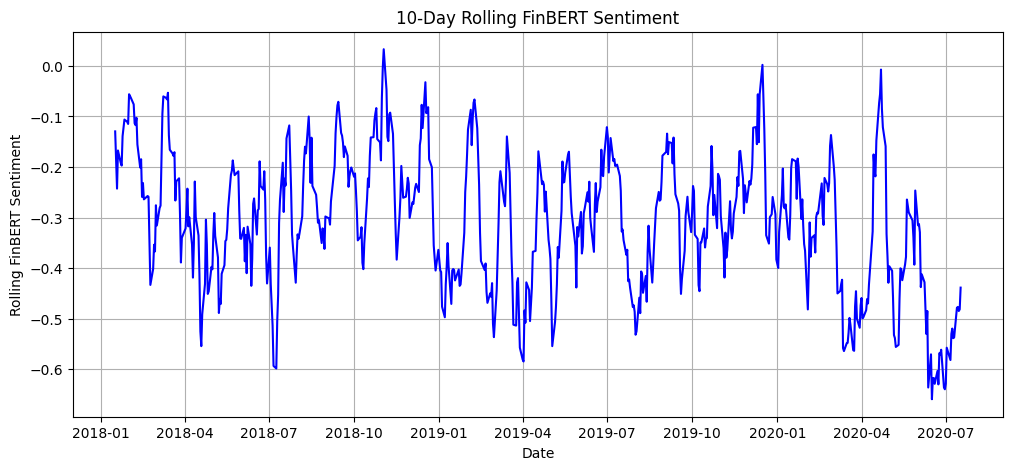

In [ ]:
plt.figure(figsize=(12,5))
rolling_finbert = finbert_signal.rolling(10).mean()
plt.plot(rolling_finbert, color='blue')
plt.title("10-Day Rolling FinBERT Sentiment")
plt.xlabel("Date")
plt.ylabel("Rolling FinBERT Sentiment")
plt.grid(True)
plt.show()

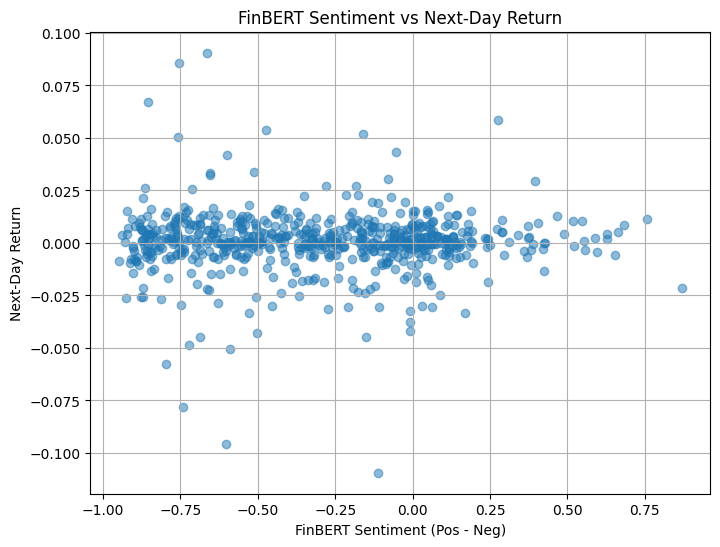

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(finbert_signal, features_df['Next_Return_'], alpha=0.5)
plt.title("FinBERT Sentiment vs Next-Day Return")
plt.xlabel("FinBERT Sentiment (Pos - Neg)")
plt.ylabel("Next-Day Return")
plt.grid(True)
plt.show()

This plot shows that there's no strong linear relationship between daily FinBERT sentiment and next day returns.

In [ ]:
features_df.columns

Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'Return_',
       'Volatility_20_', 'Next_Return_', 'Label_', 'headline_concat',
       'High_Low_Spread', 'Close_Open_Change', 'MA_5', 'MA_20', 'MA_50',
       'Return_5', 'Return_10', 'day_of_week', 'month', 'is_month_end',
       'is_quarter_end', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'finbert_positive', 'finbert_negative',
       'finbert_neutral'],
      dtype='object')

In [ ]:
features_df.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return_,1
Volatility_20_,20
Next_Return_,1
Label_,0
headline_concat,0


In [ ]:
features_df = features_df.copy()
# columns to keep
keep_cols = [
    "Close_SPY", "High_SPY", "Low_SPY", "Open_SPY", "Volume_SPY",
    "Return_", "Volatility_20_", "Next_Return_", "Label_",
    "High_Low_Spread", "Close_Open_Change",
    "MA_5", "MA_20", "MA_50",
    "Return_5", "Return_10",
    "day_of_week", "month", "is_month_end", "is_quarter_end",
    "vader_neg", "vader_neu", "vader_pos", "vader_compound",
    "finbert_positive", "finbert_negative", "finbert_neutral"
]

final_df = features_df[keep_cols].copy()
final_df = final_df.dropna()

# saving finalized dataset
final_df.to_csv("final_modeling_dataset.csv", index=True)


In [ ]:
final_df.shape

(590, 27)

In [ ]:
final_df.isna().sum()

,0
Close_SPY,0
High_SPY,0
Low_SPY,0
Open_SPY,0
Volume_SPY,0
Return_,0
Volatility_20_,0
Next_Return_,0
Label_,0
High_Low_Spread,0


## Data Dictionary

**Index**

- `Date` (DatetimeIndex)  
  - Trading day for which features are computed.  
  - News and technical features for this date are used to predict the *next* day's return/label.

---

### Price & Return Features

| Column              | Type    | Description |
|---------------------|---------|-------------|
| `Open_SPY`          | float   | Opening price of SPY on `Date`. |
| `High_SPY`          | float   | Highest intraday price of SPY on `Date`. |
| `Low_SPY`           | float   | Lowest intraday price of SPY on `Date`. |
| `Close_SPY`         | float   | Closing price of SPY on `Date`. |
| `Volume_SPY`        | float   | Trading volume of SPY on `Date`. |
| `Return_`           | float   | Daily return for `Date`: (Close - previous Close) / previous Close. |
| `Next_Return_`      | float   | Return for the *next* trading day (target in regression setting). |
| `Label_`            | int     | Binary target: 1 if `Next_Return_ > 0` (up day), 0 otherwise. |

---

### Technical / Engineered Price Features

| Column              | Type  | Description |
|---------------------|-------|-------------|
| `High_Low_Spread`   | float | `High_SPY - Low_SPY`, intraday trading range. |
| `Close_Open_Change` | float | `Close_SPY - Open_SPY`, intraday price change. |
| `MA_5`              | float | 5-day simple moving average of `Close_SPY`. |
| `MA_20`             | float | 20-day simple moving average of `Close_SPY`. |
| `MA_50`             | float | 50-day simple moving average of `Close_SPY`. |
| `Return_5`          | float | 5-day percentage return of `Close_SPY`. |
| `Return_10`         | float | 10-day percentage return of `Close_SPY`. |
| `Volatility_20_`    | float | 20-day rolling standard deviation of daily returns (`Return_`). |

---

### Calendar / Seasonality Features

| Column            | Type | Description |
|-------------------|------|-------------|
| `day_of_week`     | int  | Day of week (0 = Monday, …, 4 = Friday). |
| `month`           | int  | Month of year (1-12). |
| `is_month_end`    | int  | 1 if `Date` is the last trading day of the month, else 0. |
| `is_quarter_end`  | int  | 1 if `Date` is the last trading day of the quarter, else 0. |

---

### VADER Sentiment Features (Headline Text)

| Column           | Type  | Description |
|------------------|-------|-------------|
| `vader_neg`      | float | VADER estimated proportion of negative sentiment in that day's concatenated headlines. |
| `vader_neu`      | float | Proportion of neutral sentiment. |
| `vader_pos`      | float | Proportion of positive sentiment. |
| `vader_compound` | float | Single VADER sentiment score in \[-1, 1] summarizing overall tone. |

---

### FinBERT Sentiment Features (Headline Text)

| Column              | Type  | Description |
|---------------------|-------|-------------|
| `finbert_positive`  | float | FinBERT probability that the day's news is positive. |
| `finbert_negative`  | float | FinBERT probability that the day's news is negative. |
| `finbert_neutral`   | float | FinBERT probability that the day's news is neutral. |